# IMPORT LIBRARIES

In [1]:
# from rdflib import Graph, URIRef, Literal, RDF
import open3d as o3d
import os
from pathlib import Path
import numpy as np
import laspy
import cv2
import copy
import ezdxf
import matplotlib.pyplot as plt

#IMPORT MODULES
from context import geomapi #! only use this if you are inside geomapi
# import geomapi #! use this if you installed geomapi

from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
from geomapi.utils import imageutils as iu
from geomapi.tools import progresstools as pt
from  geomapi.utils import cadutils as cadu
from geomapi.tools import validationtools as vt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# INPUTS

In [34]:
folder='D:/Data/TUCRAIL/'
imageFolder="D:/Data/TUCRAIL/subImageNodes/"
xmlPath = folder + 'cameras_L72_0312.xml'
imgGraphPath = folder + 'imgGraph.xml'
lambertCoordinates=np.array([[263377.98,151064.413,256.924,1]]) # REF-44
imgNames=['P0024624','P0024625','P0024628','P0024688','P0024689','P0024691']
meshPath=folder +"1203.obj"
lasPath=folder + 'Project_2022-10-03_11-08-dense_point_cloud - Cloud.las'
dxf_path = folder + "Welkenraedt relevé de voies.dxf"

In [5]:
# xmlPath = "D:/studenten/LouisD/DR NIEUW/1705-undistorted/1705-cameras.xml"
# imgGraphPath = "D:/studenten/LouisD/DR NIEUW/subImageNodes/cameras_L72_1705.ttl" # RDF graph
# # lambertCoordinates=np.array([[263377.98,151064.413,256.924,1]]) # REF-44
# # imgNames=['P0024624','P0024625','P0024628','P0024688','P0024689','P0024691']
# meshPath="D:/studenten/LouisD/DR NIEUW/1705-model_reduced.obj"
# # lasPath="D:/studenten/LouisD/DR NIEUW/OmzettenCoord/0304.las"
# imageFolder="D:/studenten/LouisD/DR NIEUW/subImageNodes/"
# dxf_path = "D:/studenten/LouisD/DR NIEUW/Welkenraedt relevé de voies.dxf"

# PARSE DATA

import xml and convert to nodes

In [6]:
imgNodes=tl.img_xml_to_nodes(xmlPath,filterByFolder=True)
imgNodes=[n for n in imgNodes if n.cartesianTransform is not None]
print (f' {len(imgNodes)} Nodes created!')

 12 Nodes created!


In [7]:
#filter list because the xml contains doubles
names=[n.name for n in imgNodes]
myNodes=[]
for name in list(set(names)):
    myNodes.append(next(n for n in imgNodes if n.name == name))
imgNodes=myNodes
imgMeshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print (f' {len(imgNodes)} Nodes created!')
# temp=[n.get_resource() for n in imgNodes]

 6 Nodes created!


import mesh

In [8]:
meshNode=MeshNode(path=meshPath,getResource=True) #! set false if to heavy

import point cloud 

In [9]:
# las  = laspy.read(lasPath)
# pcdNode=PointCloudNode(resource=gmu.las_to_pcd(las))

# #apply global transformation to put it in a local coordinate system
# # pcdNode.geospatialTransform=transform
# # pcdNode.resource.transform(transform)
# print( pcdNode.resource)

Import dxf lines

In [27]:
linesets,layers=cadu.ezdxf_to_o3d(dxf_path,dtypes=['LINE'],explode_blocks=False)
import itertools
linesets = list(itertools.chain.from_iterable(linesets))
print (f' {len(linesets)} linesets created!')

Reading dxf file...
60 layers found.
22645 entities found.
Converting entities to open3d geometries...
Produced 13 open3d geometries in 13 layers.
 13 linesets created!


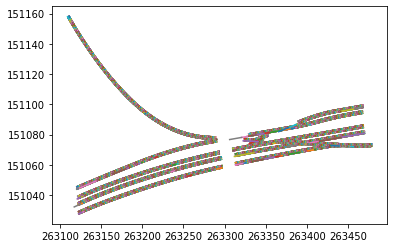

In [14]:
vt.cad_show_lines(dxf_path)

In [11]:
#oproepen wat er allemaal in een klasse zit
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///d8e52644-11a0-11ee-b3b0-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'D:/Data/TUCRAIL/P0024691.jpg',
 '_name': 'P0024691',
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': array([[ 6.17004330e-02, -9.98046378e-01,  9.82260420e-03,
          2.63380529e+05],
        [-9.98094012e-01, -6.17090662e-02, -5.77981534e-04,
          1.51069322e+05],
        [ 1.18299611e-03, -9.76822073e-03, -9.99951590e-01,
          2.81309533e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

visualize data

In [29]:
joinedImages=gmu.join_geometries(imgMeshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
for l in linesets:
    l.paint_uniform_color(ut.random_color())
o3d.visualization.draw_geometries([joinedImages]+linesets+[meshNode.resource])

# Select lines per subimage

sample lines

In [30]:
point_cloud,identityArray=cadu.sample_pcd_from_linesets(linesets,step_size=0.1)
print(point_cloud)

PointCloud with 222717 points.


In [31]:
o3d.visualization.draw_geometries([joinedImages]+linesets+[meshNode.resource]+[point_cloud])

subdivide images and select relevant linesets

In [33]:
# subdivide our images & select relevant lines
subImageNodes=[]
for n in imgNodes[0:1]: #! only do 1 image
    
    #subdivide images
    subimgList,roiList=iu.subdivide_image(n.resource,width=2000,height=1500)
    
    for img,roi in zip (subimgList,roiList):
        #compute a selection box at the location of the intersection between the roi rays and the mesh
        box=vt.create_selection_box_from_image_boundary_points(n,roi,meshNode.resource,z=5)   
                            
        #select relevant parts of the linesets
        sublinesets=vt.get_linesets_inliers_in_box(linesets,box,point_cloud,identityArray) if box is not None else []
        
        #create subImageNodes
        subImageNodes.append(ImageNode(resource=img,
                                            roi=roi,
                                            isDerivedFrom=n.subject,                                     
                                            box=box,
                                            sublinesets=sublinesets)) if len(sublinesets)>0 else None
print (f' {len(subImageNodes)} subimageNodes created!')

 18 subimageNodes created!


write subimages to drive

In [35]:
print(tl.nodes_to_graph(subImageNodes,graphPath=imgGraphPath,save=True))
[n.save_resource(imageFolder) for n in subImageNodes ]
print (f' {len(subImageNodes)} subimageNodes saved!')

[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
 18 subimageNodes saved!


visualize selection

In [36]:
n=subImageNodes[0]
o3d.visualization.draw_geometries([meshNode.resource]+[joinedImages]+ [n.box]+n.sublinesets)

In [45]:
rays=np.zeros((1,6))
for n in subImageNodes:
    # get original image
    imgNode=next(t for t in imgNodes if t.subject==n.isDerivedFrom)
    
    # example uv points (top left, middle and bottom right)
    uvCoordinates=np.array([[0,0], # top left
                            [0,n.imageWidth], # top right
                            [np.floor(n.imageHeight/2),np.floor(n.imageWidth/2)], #middle
                            [n.imageHeight,0], # bottom left
                            [n.imageHeight,n.imageWidth] # bottom right
                            ])
    # transform uvcoordinates  to world coordinates to rays   
    rays=np.vstack((rays,imgNode.create_rays(uvCoordinates)))
rays=np.delete(rays,0,axis=0) 

#cast some rays
rayLines=gmu.rays_to_lineset(rays,distances=30)

#show them
o3d.visualization.draw_geometries([meshNode.resource]+
                                  [joinedImages]+
                                    [n.box for n in subImageNodes ]+
                                     subImageNodes[0].sublinesets+
                                     [rayLines])

[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0.]
 [   0. 2000.]
 [ 750. 1000.]
 [1500.    0.]
 [1500. 2000.]]
[[   0.    0

In [74]:
{key:value for key, value in subImageNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 2000,
 'imageHeight': 1500,
 'focalLength35mm': None,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///f1afeda9-ffb8-11ed-9771-d89ef3162ab8'),
 '_graph': <Graph identifier=N755f0817ddaf45b4ba22cfc31bd8137a (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:/studenten/LouisD/DR NIEUW/subImageNodes/cameras_L72_1705.ttl',
 '_path': 'D:/studenten/LouisD/DR NIEUW/subImageNodes/f1afeda9-ffb8-11ed-9771-d89ef3162ab8.png',
 '_name': 'f1afeda9-ffb8-11ed-9771-d89ef3162ab8',
 '_timestamp': None,
 '_resource': array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
        

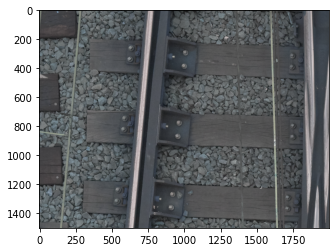

In [37]:
plt.imshow(subImageNodes[0].resource)


An RDF graph and .ttl file is created for all nodes 
(data itself is not stored in the graph, only metadata)

In [173]:
imgGraph=tl.nodes_to_graph(imgNodes,imgGraphPath,save=True)
print (f'{len(imgNodes)} Nodes succesfully serialized in: {imgGraphPath}')

6 Nodes succesfully serialized in: D:/Data/TUCRAIL/cameras_L72_0312.ttl


# PARSE IMAGEGRAPH

In [174]:
nodeList=tl.graph_path_to_nodes(imgGraphPath)
print(len(nodeList))

6


c:\Users\u0094523\.conda\envs\conda_environment3\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (102060000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [175]:
{key:value for key, value in nodeList[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 11664,
 'imageHeight': 8750,
 'focalLength35mm': 21276.5957031249,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///06332674-d1f2-11ed-8fc0-c8f75043ce59'),
 '_graph': <Graph identifier=N03cad3e1468c4e78914f6300bce7b49c (<class 'rdflib.graph.Graph'>)>,
 '_graphPath': 'D:/Data/TUCRAIL/cameras_L72_0312.ttl',
 '_path': 'D:/Data/TUCRAIL\\P0024624.jpg',
 '_name': 'P0024624',
 '_timestamp': '2023-04-03T09:33:08',
 '_resource': None,
 '_cartesianTransform': array([[-8.35427289e-02,  1.91778056e+00, -1.50033543e-02,
          2.63382830e+05],
        [ 1.91783298e+00,  8.35783123e-02,  4.25654402e-03,
          1.51064246e+05],
        [ 4.90559907e-03, -1.48038476e-02, -1.91959464e+00,
          2.81283450e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'type': 'https://w3id.org/v4d/core#ImageNode',
 'intrinsic_matrix': '[[2.12765